In [22]:
import os
from helper_edge_detection import *
from helper_data_normalization import *
from helper_pca import *
from helper_clustering import *
%matplotlib inline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [11]:
DIRECTORY = '/Users/paularescala/Documents/Professional/EPFL/ml-project-2-ml-plume-1/'

Define constants

In [12]:
PATH_TO_DATA_FOLDER = os.path.join(DIRECTORY + 'rawdata/Training_set_1k')
PATH_TO_DATA_GENERATED = os.path.join(DIRECTORY, 'generated/')

Load the data:

In [14]:
filenames, data = get_data_grayscale(PATH_TO_DATA_FOLDER)

# Pre-processing data

In [15]:
data_edges_roberts, data_edges_sobel = edge_detection(data)

In [19]:
num_samples = data_edges_roberts.shape[0]

Before PCA, we have 1000 samples, each with 20480 features
After PCA, we have 1000 samples, each with 500 features


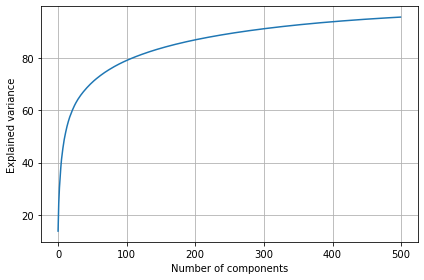

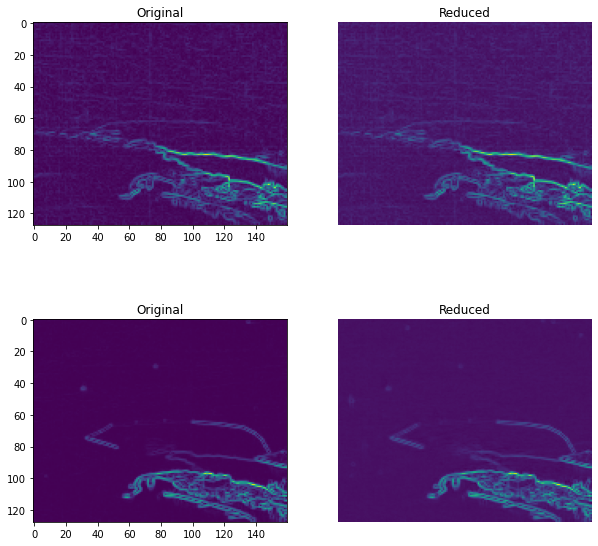

In [57]:
feature_matrix_roberts, imgs_reduced_roberts = apply_pca(data_edges_roberts, 500, plot_explained_variance = True)
idxs = np.random.choice(np.arange(num_samples), 2)
visualize_img_reduction(data_edges_roberts, imgs_reduced_roberts, idxs)

Before PCA, we have 1000 samples, each with 20480 features
After PCA, we have 1000 samples, each with 500 features


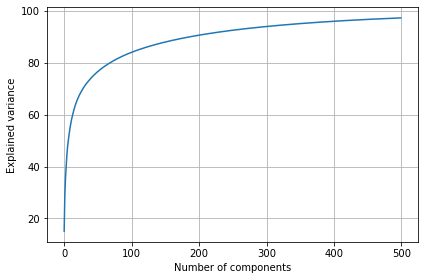

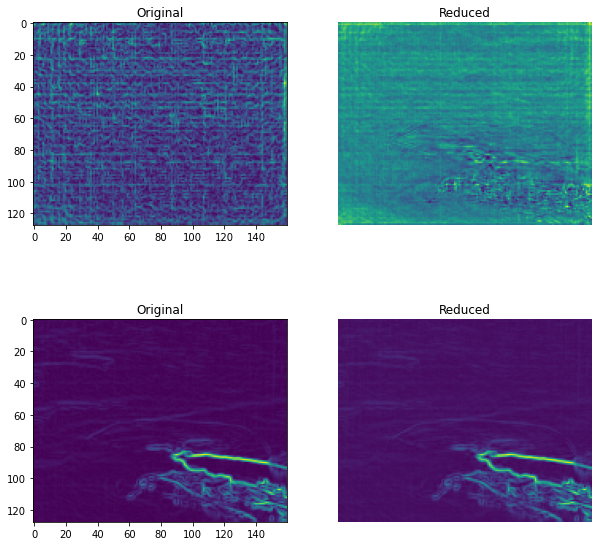

In [58]:
feature_matrix_sobel, imgs_reduced_sobel = apply_pca(data_edges_sobel, 500, plot_explained_variance = True)
idxs = np.random.choice(np.arange(num_samples), 2)
visualize_img_reduction(data_edges_sobel, imgs_reduced_sobel, idxs)

# Running kmeans clustering 

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import pandas as pd

In [59]:
def kmeans_full_analysis(data, start, end):
    silhouettes = []
    # Try multiple k
    for k in range(start, end):
        # Cluster the data and assigne the labels
        labels = KMeans(n_clusters=k, random_state=10).fit_predict(data)
        # Get the Silhouette score
        score = silhouette_score(data, labels)
        silhouettes.append({"k": k, "score": score})

    # Convert to dataframe
    silhouettes = pd.DataFrame(silhouettes)
       
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)

    fig, axs = plt.subplots(2, 1, figsize=(10,8))
    # Plot the data
    axs[0].plot(silhouettes.k, silhouettes.score)
    axs[0].set(ylabel="Silhouette score")

    # Plot the data
    axs[1].plot(sse.k, sse.sse)
    plt.xlabel("K")
    axs[1].set(ylabel="Sum of Squared Errors")
    plt.tight_layout()
    


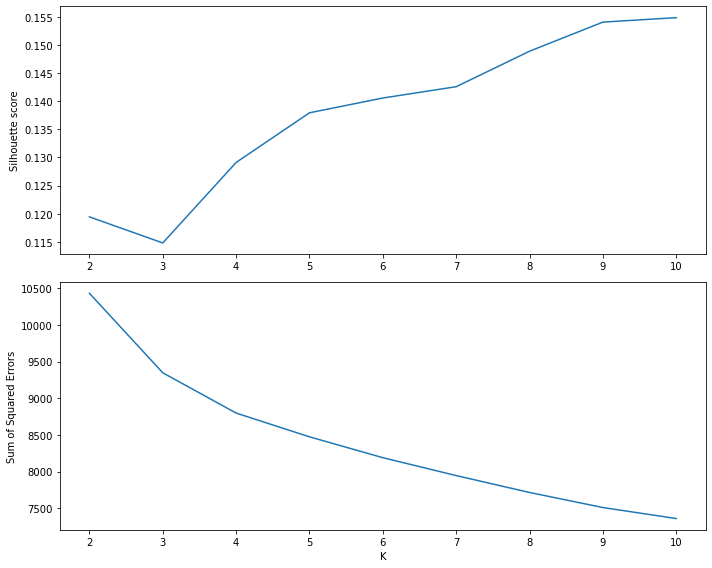

In [62]:
kmeans_full_analysis(feature_matrix_roberts, 2, 11)

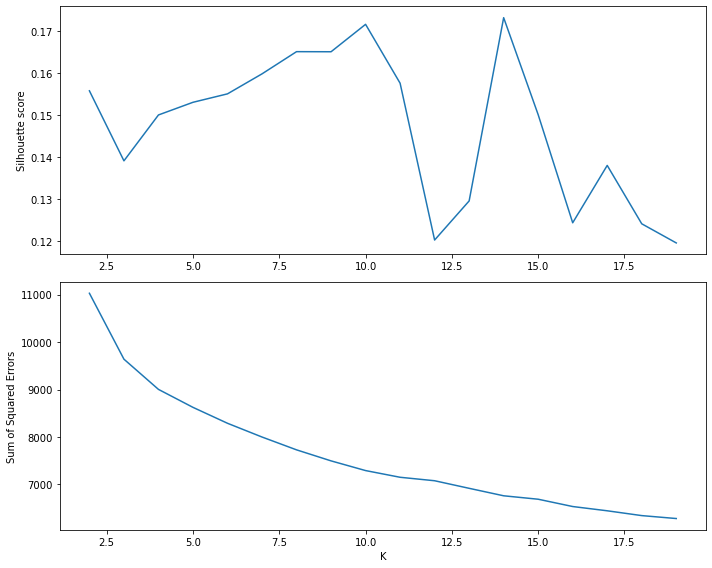

In [64]:
kmeans_full_analysis(feature_matrix_sobel,2,20)

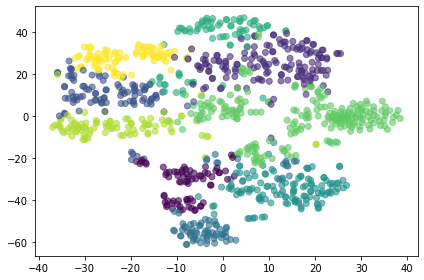

In [65]:
#fig, axs = plt.subplots(1, 2, figsize=(15,15), sharey=True)
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(feature_matrix_sobel)
labels = KMeans(n_clusters=9, random_state=0).fit_predict(feature_matrix_sobel)
# Cluster the data in 3 groups

# Plot the data reduced in 2d space with t-SNE
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
#axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
#axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
#axs[1].set_title("PCA")
plt.tight_layout()